# Jet Energy Reolution for separately central jet and forward jet

Notes: 

1. Calculates the distance(in terms of deltaR) between each jet and gen jet in terms of eta and phi
2. Finds the closest gen jet to each jet based on the calculated distance
3. Add an upper cut(deltaR is below 0.4) to avoid issues just to avoid fat tails in the resolution
4. Calculates the ratio of Jet.PT to GenJet.PT for each pair of jet and gen jet for each of the event
5. For RMSE, define some pT binning, group the jets according to that, calculate the RMSE of the ratio separately for each bin using jets belonging to that bin
6. Draw 2D plot between PT_Jet and RMSE(ratio)

#### These numbers which we will get need to be compared to resolution numbers appearing in ATLAS jet/MET paper https://arxiv.org/pdf/2007.02645.pdf
#### and based on that we should decide if we tweak the delphes parameters up or down (and make another sample).
#### See Fig.26a, 29a and 30 and need to just make sure the compatibility with ATLAS is reasonable in regions where we have most of our jets

--> Jet.PT is using instead of Jet.Energy

In [11]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def jet_energy_resolution(root_file):

    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store Jet PT and corresponding ratios for both central jets and forward jets
    central_jet_pts = []
    central_ratios = []
    forward_jet_pts = []
    forward_ratios = []

    pt_bins = np.linspace(0, 1201, 30)  # 50 bins from 0 to 1301 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []
    forward_ratios_rmse_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Lists to store Jet PT and corresponding ratios for central jets and forward jets in current event
        central_jet_pts_event = []
        central_ratios_event = []
        forward_jet_pts_event = []
        forward_ratios_event = []
        
        # Loop over each jet and its corresponding gen jet
        for i in range(num_jets):
            jet = branchJet.At(i)
            
            # Find the closest gen jet to the jet in terms of deltaR
            closest_gen_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_gen_jets):
                gen_jet = branchGenJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_gen_jet = gen_jet
                    
            # Calculate the ratio of Jet.PT to GenJet.PT
            if closest_gen_jet:
                jet_pt_ratio = jet.PT / closest_gen_jet.PT
                if abs(jet.Eta) < 2.4:                          # Central jets: |eta| < 2.4
                    central_jet_pts_event.append(jet.PT)
                    central_ratios_event.append(jet_pt_ratio)
                else:                                           # Forward jets: |eta| >= 2.4
                    forward_jet_pts_event.append(jet.PT)
                    forward_ratios_event.append(jet_pt_ratio)
                    
        # End event loop, extend main lists
        central_jet_pts.extend(central_jet_pts_event)
        central_ratios.extend(central_ratios_event)
        forward_jet_pts.extend(forward_jet_pts_event)
        forward_ratios.extend(forward_ratios_event)

    # Convert lists to numpy arrays for plotting
    central_jet_pts = np.array(central_jet_pts)
    central_ratios = np.array(central_ratios)
    forward_jet_pts = np.array(forward_jet_pts)
    forward_ratios = np.array(forward_ratios)

    # Calculate RMSE of ratios while passing all jets which gives constant

    # central_ratios_rmse = np.std(central_ratios)
    # forward_ratios_rmse = np.std(central_ratios)

    # Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_jet_pts_bin = central_jet_pts[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        forward_jet_pts_bin = forward_jet_pts[(forward_jet_pts >= pt_bins[i]) & (forward_jet_pts < pt_bins[i + 1])]
        forward_ratios_bin = forward_ratios[(forward_jet_pts >= pt_bins[i]) & (forward_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE for central jets
        central_ratios_rmse_bin = np.std(central_ratios_bin)
        central_ratios_rmse_bins.append(central_ratios_rmse_bin)
        
        # Calculate RMSE for forward jets
        forward_ratios_rmse_bin = np.std(forward_ratios_bin)
        forward_ratios_rmse_bins.append(forward_ratios_rmse_bin)

    # Plotting

    # Jet PT to GenJet PT ratios
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(central_ratios, bins=50, range=(0, 5), histtype='step', color='blue', linewidth=2)
    plt.xlabel('Jet PT / GenJet PT')
    plt.ylabel('Frequency')
    plt.title('Central Jets: Ratio of Jet PT to GenJet PT')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(forward_ratios, bins=50, range=(0, 5), histtype='step', color='red', linewidth=2)
    plt.xlabel('Jet PT / GenJet PT')
    plt.ylabel('Frequency')
    plt.title('Forward Jets: Ratio of Jet PT to GenJet PT')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # # RMSE of Jet PT to GenJet PT ratios
    # plt.figure(figsize=(10, 5))

    # plt.subplot(1, 2, 1)
    # plt.hist(central_ratios_rmse, bins=50, range=(0, 5), histtype='step', color='blue', linewidth=2)
    # plt.xlabel('RMSE(Jet PT / GenJet PT)')
    # plt.ylabel('')
    # plt.title('Central Jets: RMSE Ratio of Jet PT to GenJet PT')
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.hist(forward_ratios_rmse, bins=50, range=(0, 5), histtype='step', color='red', linewidth=2)
    # plt.xlabel('RMSE(Jet PT / GenJet PT)')
    # plt.ylabel('')
    # plt.title('Forward Jets: RMSE Ratio of Jet PT to GenJet PT')
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

    # 2D plot of Jet PT vs ratio
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(central_jet_pts, central_ratios, s=5, c='blue', alpha=0.5)
    plt.xlabel('Jet PT')
    plt.ylabel('Jet PT / GenJet PT')
    plt.title('Central Jets: Jet PT vs Jet PT / GenJet PT')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(forward_jet_pts, forward_ratios, s=5, c='red', alpha=0.5)
    plt.xlabel('Jet PT')
    plt.ylabel('Jet PT / GenJet PT')
    plt.title('Forward Jets: Jet PT vs Jet PT / GenJet PT')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # RMSE Separate

    plt.figure(figsize=(10, 5))

    # Central jets plot
    plt.subplot(1, 2, 1)
    plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7)
    plt.xlabel('Jet PT')
    plt.ylabel('RMSE of Jet PT / GenJet PT')
    plt.title('Central Jets: Jet PT vs RMSE of Jet PT / GenJet PT')
    plt.grid(True)

    # print("Central Jets:")
    # for i in range(len(pt_bins[:-1])):
    #     print("PT Bin:", pt_bins[i], "-", pt_bins[i+1])
    #     print("RMSE:", central_ratios_rmse_bins[i])

    # Forward jets plot
    plt.subplot(1, 2, 2)
    plt.scatter(pt_bins[:-1], forward_ratios_rmse_bins, s=100, c='red', alpha=0.7)
    plt.xlabel('Jet PT')
    plt.ylabel('RMSE of Jet PT / GenJet PT')
    plt.title('Forward Jets: Jet PT vs RMSE of Jet PT / GenJet PT')
    plt.grid(True)

    # print("\nForward Jets:")
    # for i in range(len(pt_bins[:-1])):
    #     print("PT Bin:", pt_bins[i], "-", pt_bins[i+1])
    #     print("RMSE:", forward_ratios_rmse_bins[i])

    plt.tight_layout()
    plt.show()

    # RMSE same Canvas
    # plt.figure(figsize=(10, 5))

    # plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', label='Central Jets', alpha=0.7)
    # plt.scatter(pt_bins[:-1], forward_ratios_rmse_bins, s=100, c='red', label='Forward Jets', alpha=0.7)

    # plt.xlabel('Jet PT')
    # plt.ylabel('RMSE of Jet PT / GenJet PT')
    # plt.title('Jet PT vs RMSE of Jet PT / GenJet PT')
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()


/home/rhammad/anaconda3/envs/root_env/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rhammad/anaconda3/envs/root_env/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/rhammad/anaconda3/envs/root_env/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


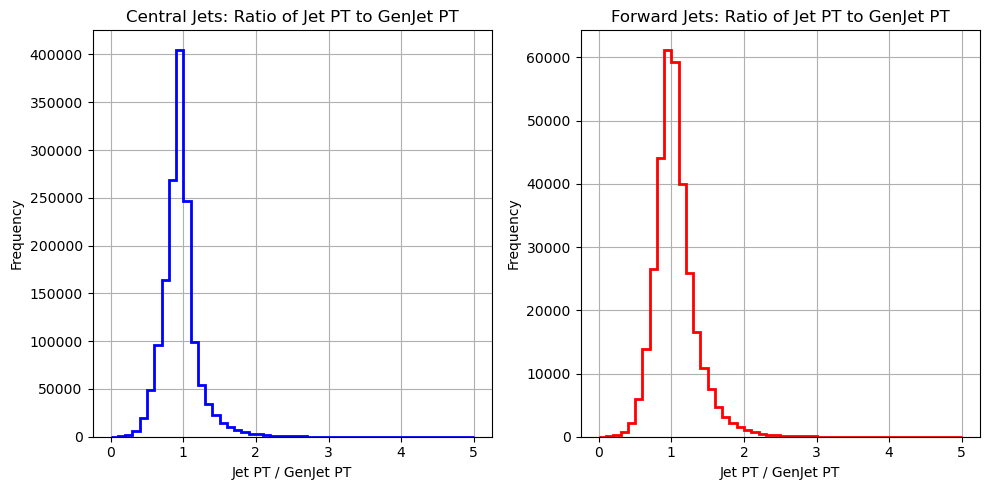

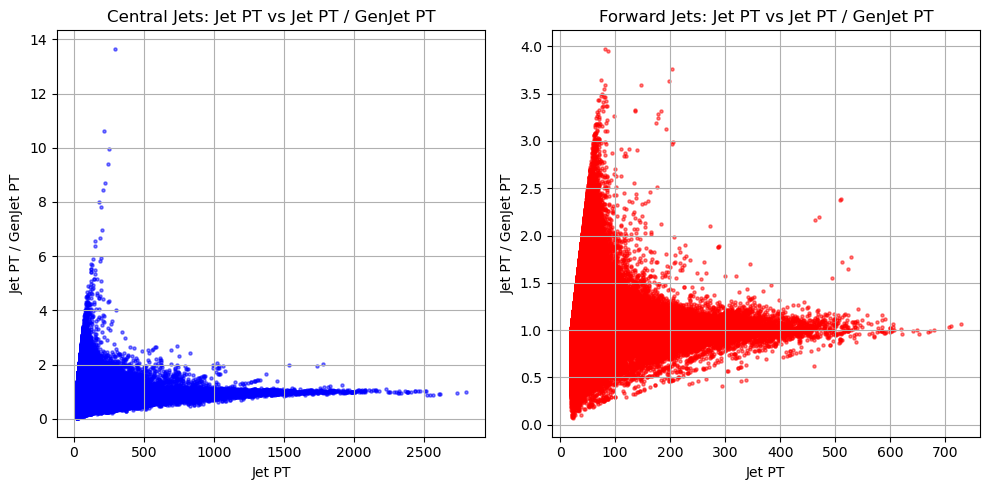

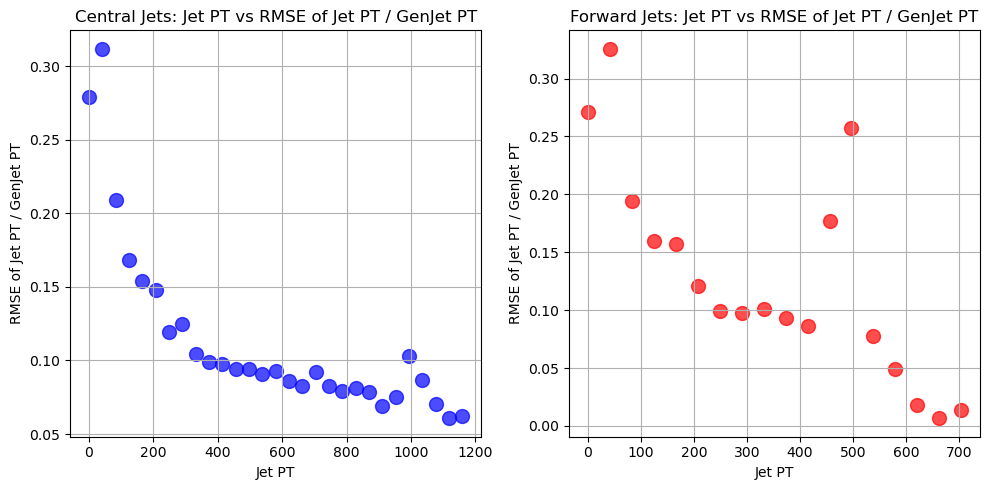

In [12]:
jet_energy_resolution("/data/analysis/rhammad/merged_all_100k_pileUp.root")

# For N1 900 GeV ; gl 1000 GeV ; 100k events ; using CKKW

In [10]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt
#np.set_printoptions(threshold=np.inf)

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution(root_file_path):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store Jet PT and corresponding ratios for central jets and forward jets
    central_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(15)/math.log(10), math.log(1501)/math.log(10), 30)  # 50 bins from 15 to 1501 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each jet and its corresponding gen jet
        for i in range(num_jets):
            jet = branchJet.At(i)
            
            # Find the closest gen jet to the jet in terms of deltaR
            closest_gen_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_gen_jets):
                gen_jet = branchGenJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_gen_jet = gen_jet
                    
            # Calculate the ratio of Jet.PT to GenJet.PT
            if closest_gen_jet and 0.2 <= abs(jet.Eta) < 0.7:  # Selecting jets in the specified eta range
                jet_pt_ratio = jet.PT / closest_gen_jet.PT
                central_jet_pts.append(jet.PT)
                central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    central_jet_pts = np.array(central_jet_pts)
    central_ratios = np.array(central_ratios)

    # Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        # Print out data for specific bins
        if pt_bins[i] >= 98 and pt_bins[i + 1] <= 310:
            print(f"Bin {i}: PT Range: {pt_bins[i]} - {pt_bins[i + 1]}, Number of Jets: {len(central_ratios_bin)}, Ratios: {central_ratios_bin}\n")
        # Calculate RMSE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin) # Use np.nanstd to ignore NaN values
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
            if pt_bins[i] >= 98 and pt_bins[i + 1] <= 310:
                print(f"RMSE Ratios for Bin {i}: {central_ratios_rmse_bin}\n")
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data


    # RMSE of Jet PT to GenJet PT ratios
    plt.figure(figsize=(10, 5))

    plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7)
    plt.xlabel('Jet PT')
    plt.ylabel('RMSE of Jet PT / GenJet PT')
    plt.title('Jet PT vs RMSE of Jet PT / GenJet PT ')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(ticks=pt_bins, labels=[f"{int(pt)}" for pt in pt_bins], rotation=45)
    plt.savefig("energy_resolution.png")
    plt.show()

    for i in range(len(pt_bins) - 1):
    # Select jets within the current pT bin
        central_jet_pts_bin = central_jet_pts[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        # Plot histogram for specific bins
        if pt_bins[i] >= 98 and pt_bins[i + 1] <= 310:
            plt.figure()
            plt.hist(central_jet_pts_bin, bins=20, color='blue', alpha=0.7)
            plt.xlabel('Jet PT')
            plt.ylabel('Frequency')
            plt.title(f'Histogram of Jet PT for Bin {i}: PT Range: {pt_bins[i]} - {pt_bins[i + 1]}')
            plt.grid(True)
            plt.show()

    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        # Plot scatter plot for specific bins
        if pt_bins[i] >= 98 and pt_bins[i + 1] <= 310:
            plt.figure()
            plt.scatter(central_jet_pts[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])],central_ratios_bin, s=100, c='blue', alpha=0.7)
            plt.xlabel('Jet PT')
            plt.ylabel('Jet PT / GenJet PT')
            plt.title(f'Scatter Plot of Jet PT vs. GenJet PT Ratios for Bin {i}: PT Range: {pt_bins[i]} - {pt_bins[i + 1]}')
            plt.grid(True)
            plt.xscale('log')
            plt.show()

    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        # Print statistical summary for specific bins
        if pt_bins[i] >= 98 and pt_bins[i + 1] <= 310:
            print(f"Bin {i}: PT Range: {pt_bins[i]} - {pt_bins[i + 1]}")
            print("Jet PT:")
            print(f"Mean: {np.mean(central_jet_pts_bin)}")
            print(f"Median: {np.median(central_jet_pts_bin)}")
            print(f"Standard Deviation: {np.std(central_jet_pts_bin)}")
            print("Jet PT / GenJet PT Ratios:")
            print(f"Mean: {np.mean(central_ratios_bin)}")
            print(f"Median: {np.median(central_ratios_bin)}")
            print(f"Standard Deviation: {np.std(central_ratios_bin)}")
            print()


# merge all 100k events

Bin 12: PT Range: 100.87817840296529 - 118.24226195313506, Number of Jets: 16683, Ratios: [1.19154545 0.86314146 0.94204025 ... 0.90157901 1.14848931 0.82098022]

RMSE Ratios for Bin 12: 0.20483848783076736

Bin 13: PT Range: 118.24226195313506 - 138.59521189949288, Number of Jets: 15856, Ratios: [1.23284159 0.98950525 0.90331945 ... 0.92710479 1.01098521 0.9367192 ]

RMSE Ratios for Bin 13: 0.19121872721632036

Bin 14: PT Range: 138.59521189949288 - 162.451499524583, Number of Jets: 14779, Ratios: [0.86050294 0.8618371  0.51248891 ... 0.87368464 0.95097612 1.07704525]

RMSE Ratios for Bin 14: 0.1564430119969743

Bin 15: PT Range: 162.451499524583 - 190.414151658598, Number of Jets: 13313, Ratios: [1.08521684 1.01845811 1.13150588 ... 0.98431432 1.03959637 0.64202703]

RMSE Ratios for Bin 15: 0.15615055792956978

Bin 16: PT Range: 190.414151658598 - 223.1899936779402, Number of Jets: 12663, Ratios: [0.97160914 0.90483716 0.8934141  ... 0.95838794 0.86110888 0.86423152]

RMSE Ratios for

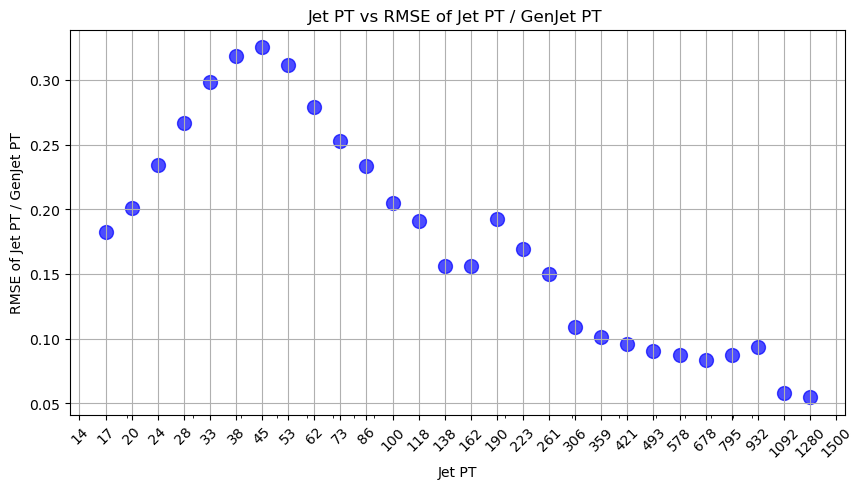

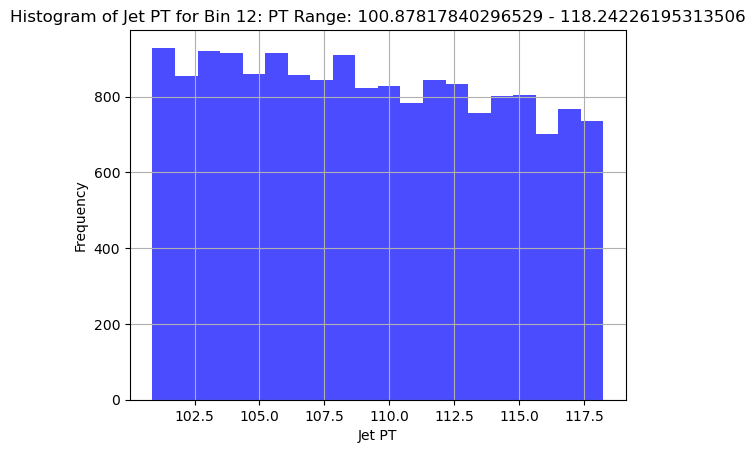

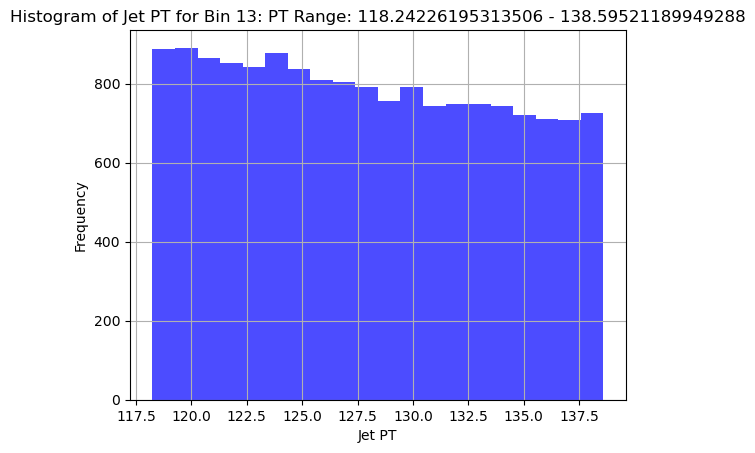

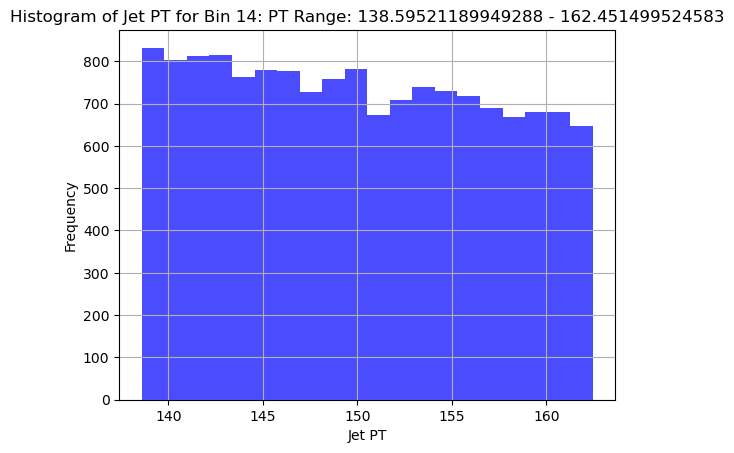

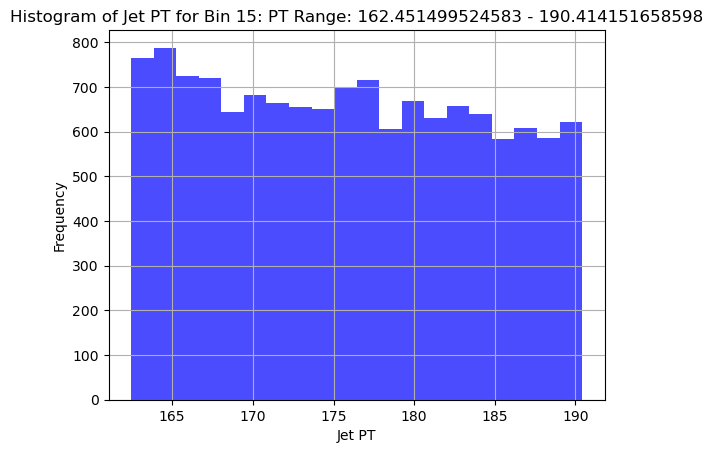

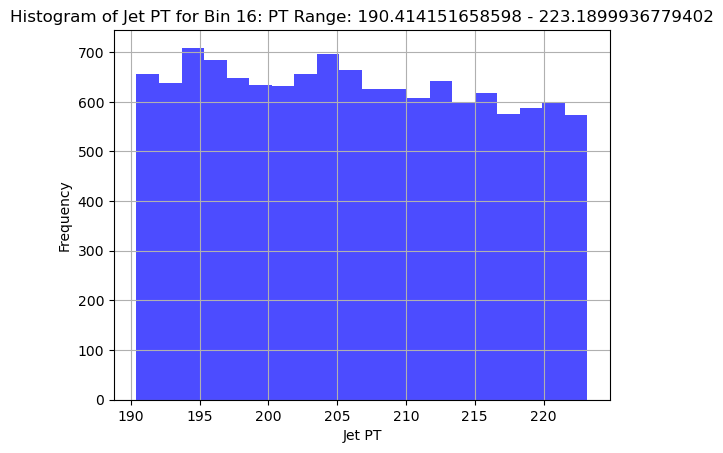

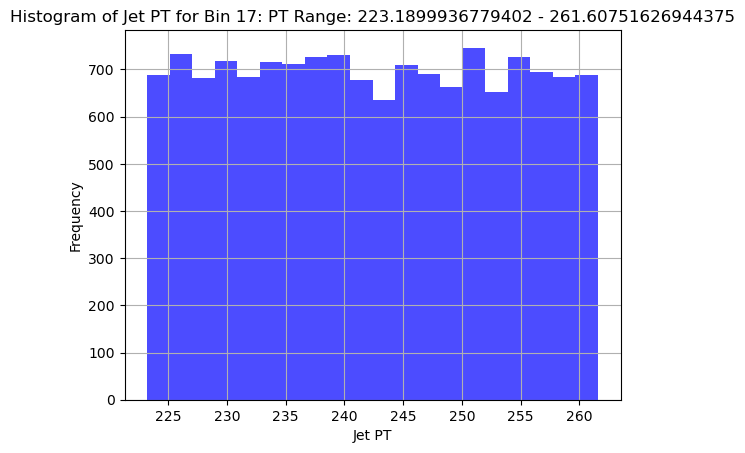

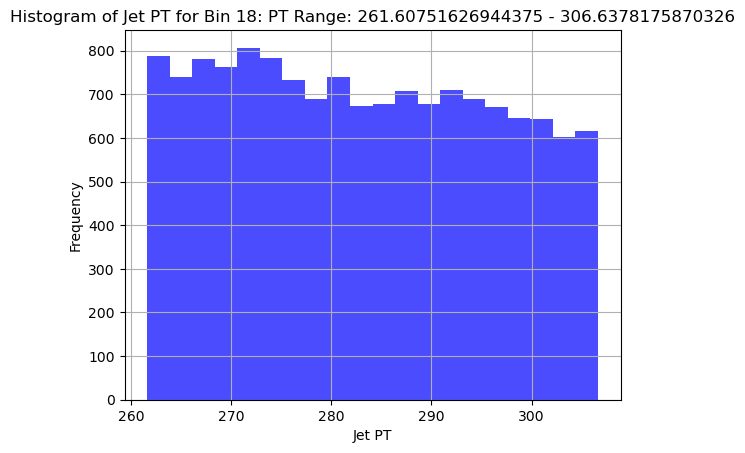

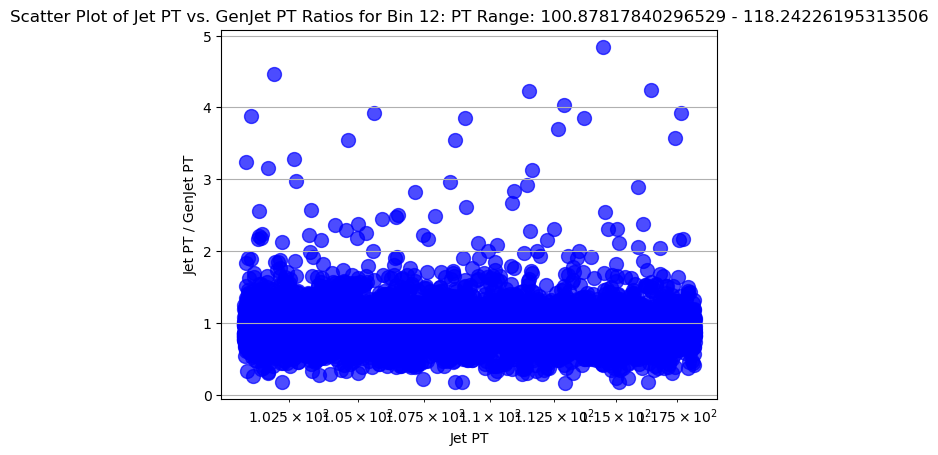

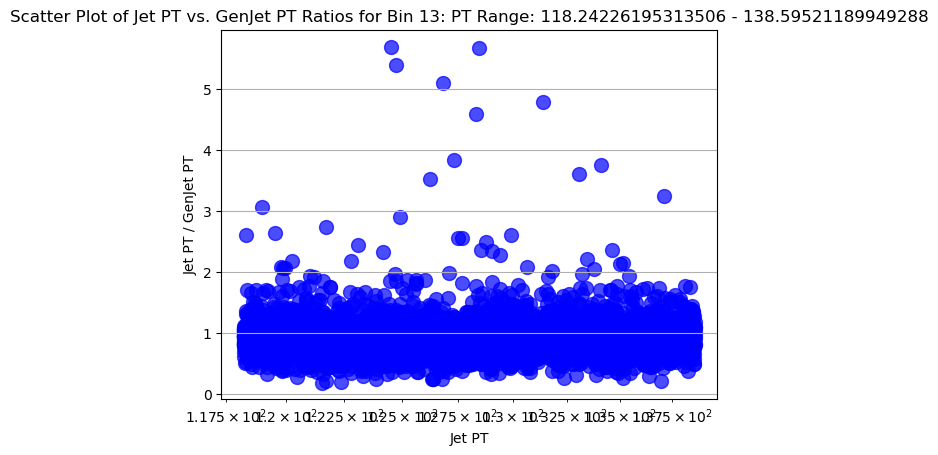

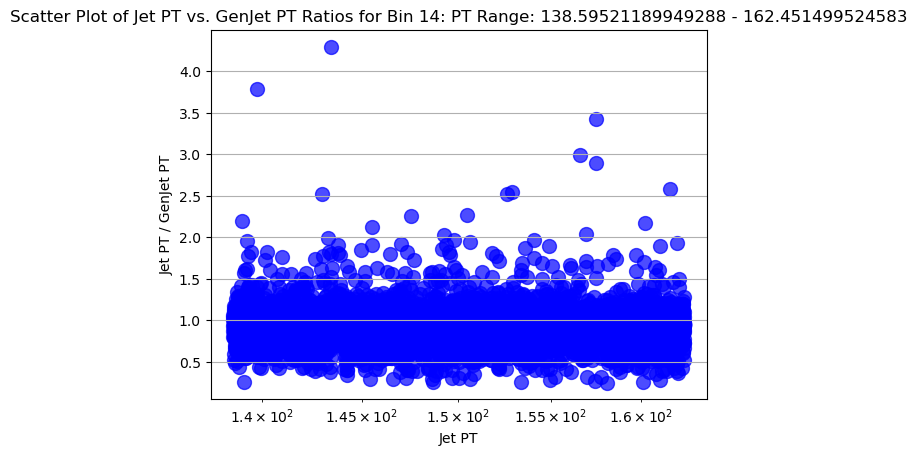

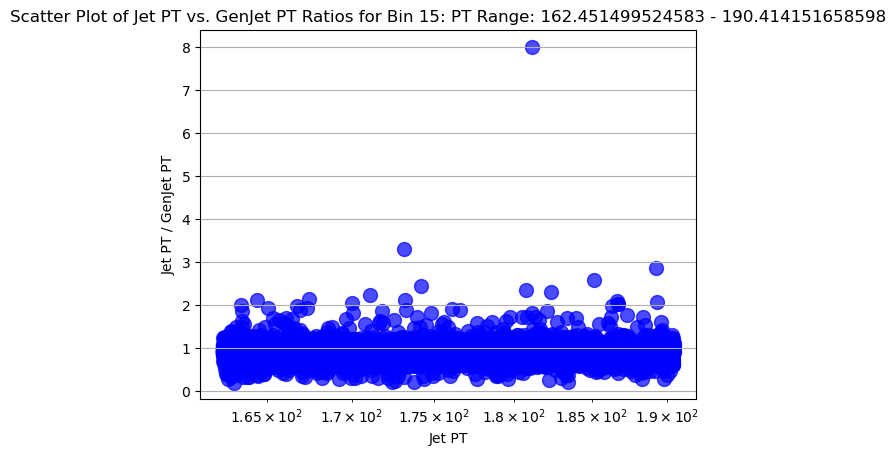

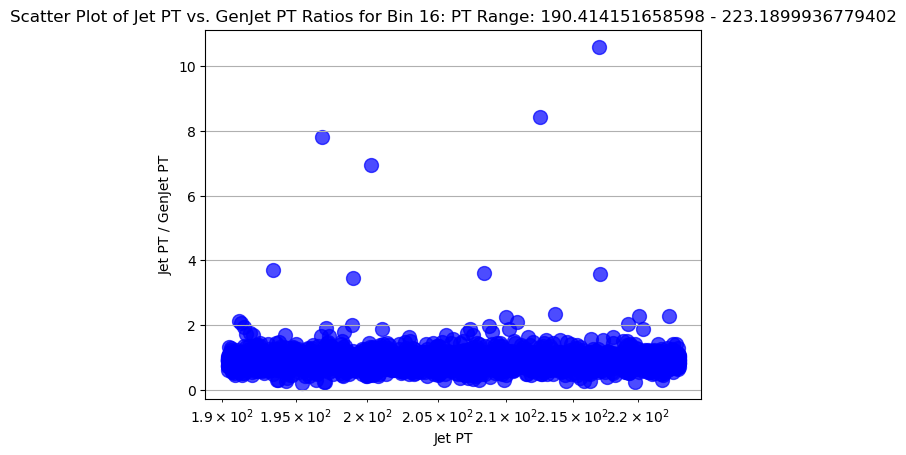

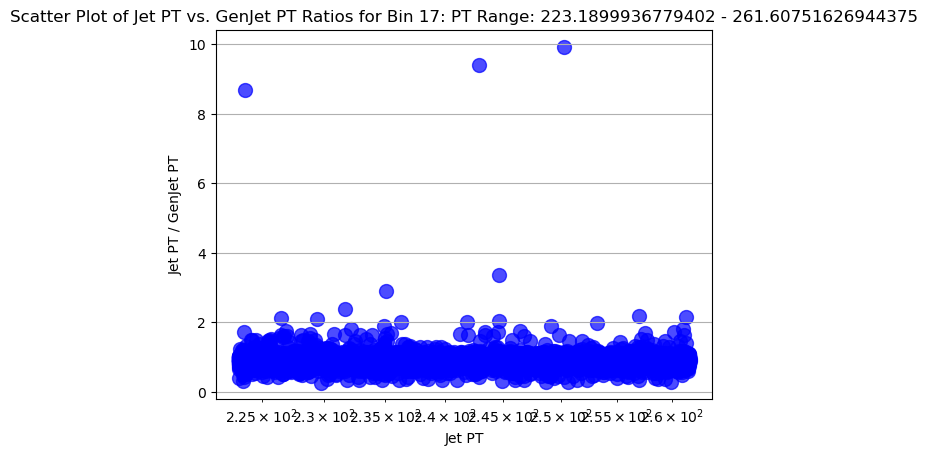

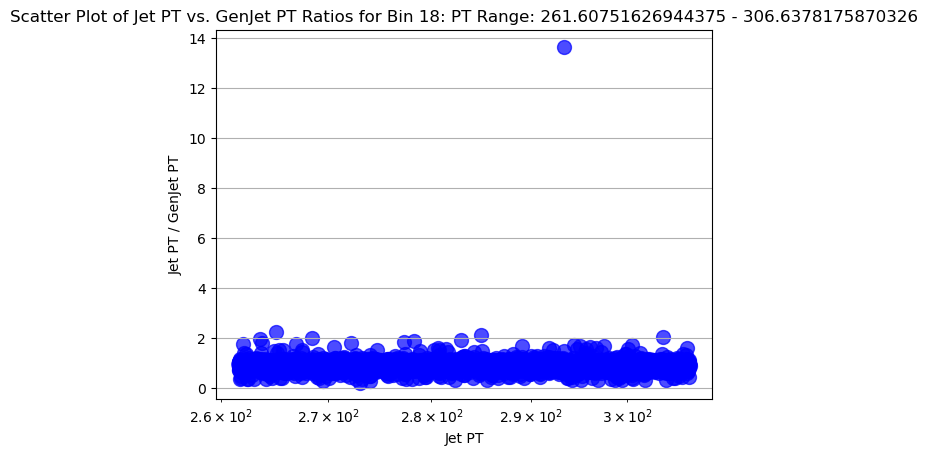

Bin 12: PT Range: 100.87817840296529 - 118.24226195313506
Jet PT:
Mean: 1368.7763779098923
Median: 1360.9823608398438
Standard Deviation: 58.03683441464536
Jet PT / GenJet PT Ratios:
Mean: 0.928245430587705
Median: 0.9072229717729267
Standard Deviation: 0.20483848783076736

Bin 13: PT Range: 118.24226195313506 - 138.59521189949288
Jet PT:
Mean: 1368.7763779098923
Median: 1360.9823608398438
Standard Deviation: 58.03683441464536
Jet PT / GenJet PT Ratios:
Mean: 0.9266911183813301
Median: 0.910408742538954
Standard Deviation: 0.19121872721632036

Bin 14: PT Range: 138.59521189949288 - 162.451499524583
Jet PT:
Mean: 1368.7763779098923
Median: 1360.9823608398438
Standard Deviation: 58.03683441464536
Jet PT / GenJet PT Ratios:
Mean: 0.9249547570116654
Median: 0.9203156274327872
Standard Deviation: 0.1564430119969743

Bin 15: PT Range: 162.451499524583 - 190.414151658598
Jet PT:
Mean: 1368.7763779098923
Median: 1360.9823608398438
Standard Deviation: 58.03683441464536
Jet PT / GenJet PT Ratios

In [11]:
energy_resolution("/data/analysis/rhammad/merged_all_100k_pileUp.root")

In [4]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution_1st_suggestion(root_file_path, min_ratio=0.5, max_ratio=2.0):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store Jet PT and corresponding ratios for central jets and forward jets
    central_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(15)/math.log(10), math.log(1501)/math.log(10), 30)  # 50 bins from 0 to 1301 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each jet and its corresponding gen jet
        for i in range(num_jets):
            jet = branchJet.At(i)
            
            # Find the closest gen jet to the jet in terms of deltaR
            closest_gen_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_gen_jets):
                gen_jet = branchGenJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_gen_jet = gen_jet
                    
            # Calculate the ratio of Jet.PT to GenJet.PT
            if closest_gen_jet and 0.2 <= abs(jet.Eta) < 0.7:  # Selecting jets in the specified eta range
                jet_pt_ratio = jet.PT / closest_gen_jet.PT
                if min_ratio <= jet_pt_ratio <= max_ratio:  # Consider ratios within a reasonable range
                    central_jet_pts.append(jet.PT)
                    central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    central_jet_pts = np.array(central_jet_pts)
    central_ratios = np.array(central_ratios)

    # Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select jets within the current pT bin
        central_ratios_bin = central_ratios[(central_jet_pts >= pt_bins[i]) & (central_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin) # Use np.nanstd to ignore NaN values
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data

    # RMSE of Jet PT to GenJet PT ratios
    plt.figure(figsize=(10, 5))

    plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7)
    plt.xlabel('Jet PT')
    plt.ylabel('RMSE of Jet PT / GenJet PT')
    plt.title('Jet PT vs RMSE of Jet PT / GenJet PT ')
    plt.grid(True)
    plt.xscale('log')
    plt.savefig("energy_resolution.png")
    plt.show()



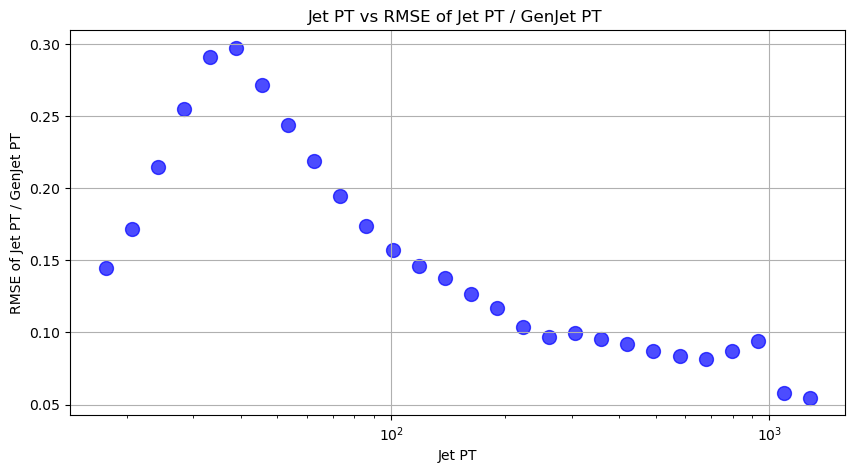

In [5]:
energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.5, 2.0)

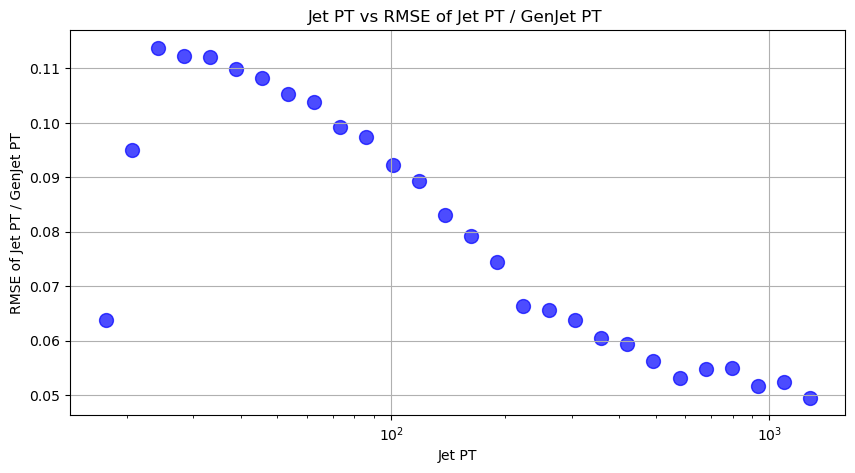

In [11]:
energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.8, 1.2)

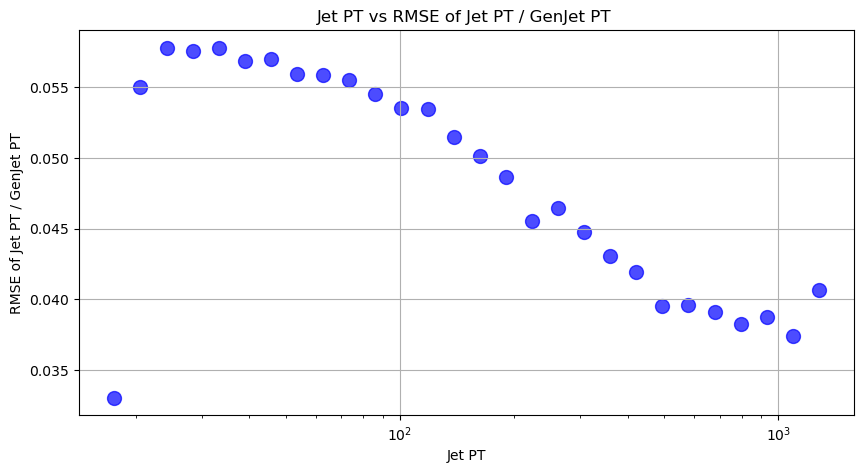

In [12]:
energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.9, 1.1)

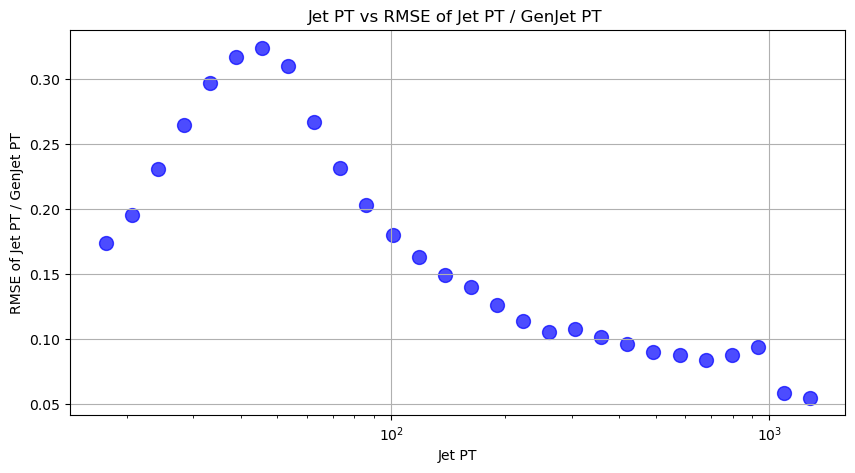

In [13]:

energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.3, 3.0)

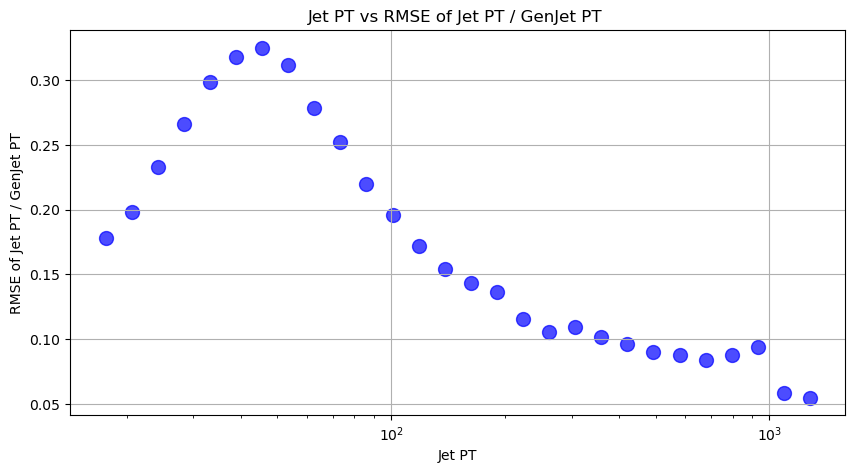

In [14]:

energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.2, 4.0)

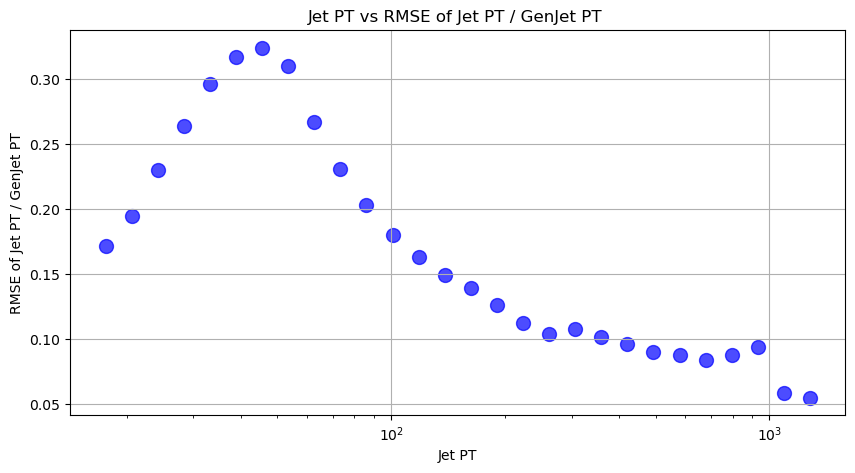

In [6]:
energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.3333, 3.0)

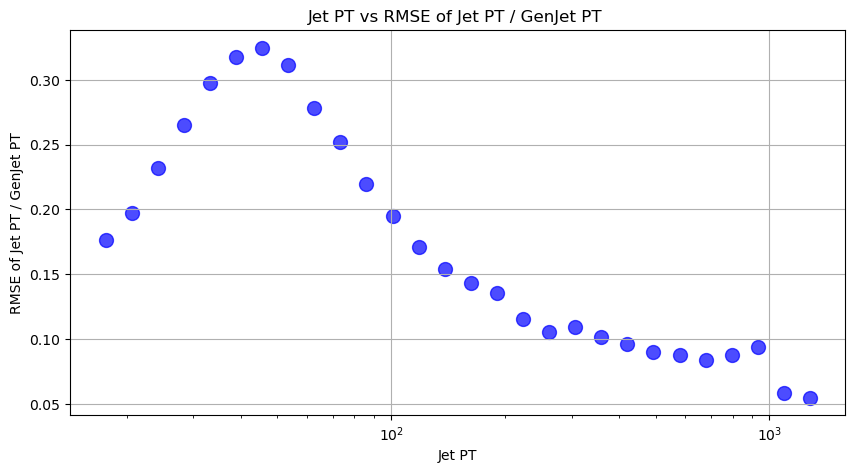

In [7]:
energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.25, 4.0)

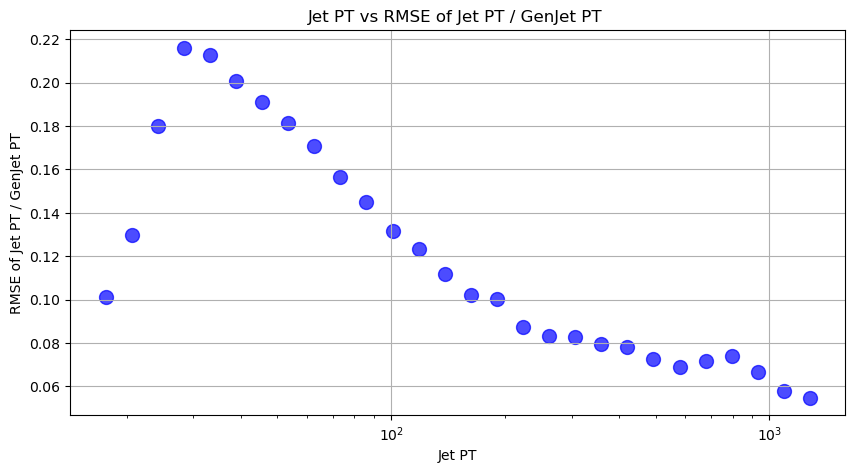

In [8]:
energy_resolution_1st_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.6666, 1.5)

In [16]:
import ROOT
import numpy as np
import math
import matplotlib.pyplot as plt

ROOT.gSystem.Load("libDelphes")

try:
    ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass

def energy_resolution_2nd_suggestion(root_file_path, min_ratio, max_ratio):
    # Create chain of root trees
    chain = ROOT.TChain("Delphes")
    chain.Add(root_file_path)

    # Create object of class ExRootTreeReader
    treeReader = ROOT.ExRootTreeReader(chain)
    numberOfEntries = treeReader.GetEntries()

    # Get pointers to the branches containing Jet and GenJet information
    branchJet = treeReader.UseBranch("Jet")
    branchGenJet = treeReader.UseBranch("GenJet")

    # Lists to store GenJet PT and corresponding ratios for central jets and forward jets
    gen_jet_pts = []
    central_ratios = []

    pt_bins = np.logspace(math.log(15)/math.log(10), math.log(1501)/math.log(10), 30)  # 50 bins from 0 to 1301 GeV

    # Lists to store RMSE for each pT bin
    central_ratios_rmse_bins = []

    # Loop over all events
    for entry in range(numberOfEntries):
        # Load selected branches with data from specified event
        treeReader.ReadEntry(entry)
        
        num_jets = branchJet.GetEntries()
        num_gen_jets = branchGenJet.GetEntries()
        
        # Loop over each gen jet and find the closest reco jet
        for i in range(num_gen_jets):
            gen_jet = branchGenJet.At(i)
            
            # Find the closest reco jet to the gen jet in terms of deltaR
            closest_jet = None
            min_delta_r = 999999.0
            
            for j in range(num_jets):
                jet = branchJet.At(j)
                
                delta_eta = jet.Eta - gen_jet.Eta
                delta_phi = ROOT.TVector2.Phi_mpi_pi(jet.Phi - gen_jet.Phi)
                delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
                if delta_r < 0.4:
                    if delta_r < min_delta_r:
                        min_delta_r = delta_r
                        closest_jet = jet
                    
            # Calculate the ratio of RecoJet.PT to GenJet.PT
            if closest_jet and 0.2 <= abs(gen_jet.Eta) < 0.7:  # Selecting gen jets in the specified eta range
                jet_pt_ratio = closest_jet.PT / gen_jet.PT
                if min_ratio <= jet_pt_ratio <= max_ratio:  # Consider ratios within a reasonable range
                    gen_jet_pts.append(gen_jet.PT)
                    central_ratios.append(jet_pt_ratio)

    # Convert lists to numpy arrays for plotting
    gen_jet_pts = np.array(gen_jet_pts)
    central_ratios = np.array(central_ratios)

    # Loop over each pT bin for RMSE calculation separately for each bin using jets belonging to that bin
    for i in range(len(pt_bins) - 1):
        # Select gen jets within the current pT bin
        central_ratios_bin = central_ratios[(gen_jet_pts >= pt_bins[i]) & (gen_jet_pts < pt_bins[i + 1])]
        
        # Calculate RMSE for central jets
        if len(central_ratios_bin) > 0:
            central_ratios_rmse_bin = np.nanstd(central_ratios_bin) # Use np.nanstd to ignore NaN values
            central_ratios_rmse_bins.append(central_ratios_rmse_bin)
        else: # Handle the case where there are no elements in the slice
            central_ratios_rmse_bins.append(np.nan)  # or any other value to signify no data

    # RMSE of GenJet PT to RecoJet PT ratios
    plt.figure(figsize=(10, 5))

    plt.scatter(pt_bins[:-1], central_ratios_rmse_bins, s=100, c='blue', alpha=0.7)
    plt.xlabel('GenJet PT')
    plt.ylabel('RMSE of RecoJet PT / GenJet PT')
    plt.title('GenJet PT vs RMSE of RecoJet PT / GenJet PT ')
    plt.grid(True)
    plt.xscale('log')
    plt.show()



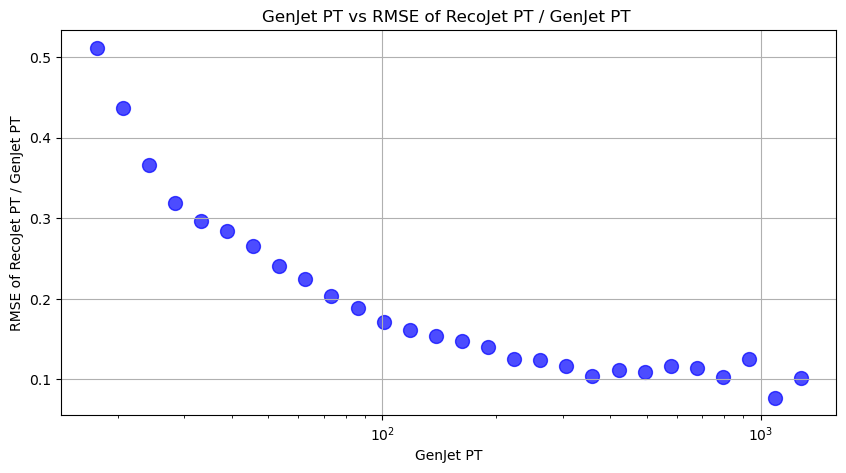

In [20]:
energy_resolution_2nd_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", -100000, 1000000)

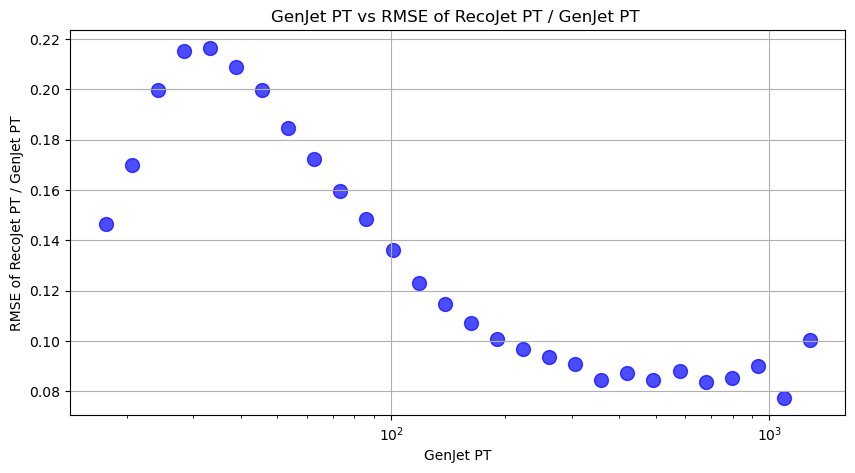

In [19]:
energy_resolution_2nd_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.6, 1.5)

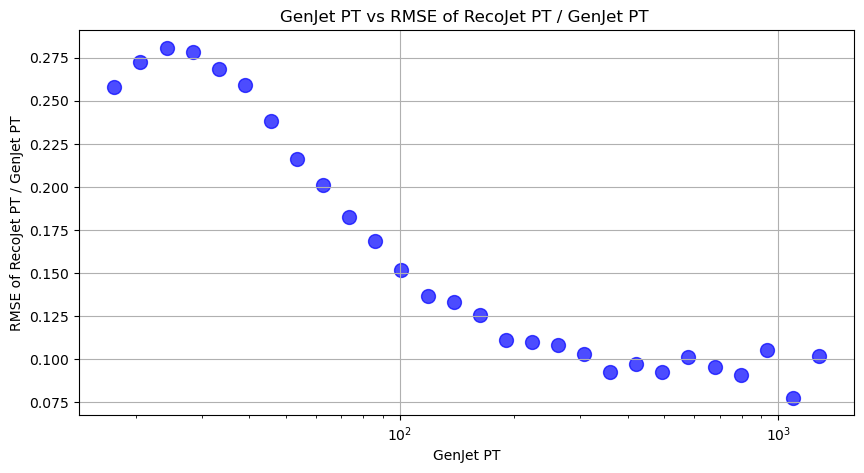

In [18]:
energy_resolution_2nd_suggestion("/data/analysis/rhammad/merged_all_100k_pileUp.root", 0.5, 2.0)